In [1]:
# load pngs -> dali dataloader #
################################

wsi_seq = '20230815_142150'

base_dir = "/mnt/bigdata/placenta/"

import dali
import torch
import numpy as np
from pathlib import Path
from nvidia.dali.plugin.pytorch import LastBatchPolicy
from nvidia.dali.plugin.pytorch import DALIClassificationIterator

base_dir = Path(base_dir)
tile_dir = base_dir / Path("tiles/" + wsi_seq +"/")

batch_size = 64 # need to find max that fits into the memory

eii = dali.ExternalInputIterator(tile_dir, batch_size)

pipe = dali.ExternalSourcePipeline(
    batch_size=batch_size, 
    num_threads=16,
    external_data = eii)

pii = DALIClassificationIterator(pipe, last_batch_padded=True, last_batch_policy=LastBatchPolicy.PARTIAL)


In [2]:
# load model #
##############

model_checkpoint_file = "/mnt/bigdata/placenta/training_checkpoints/vague-smilodon15.ckpt"

from nvidia_resnets.resnet import (
    se_resnext101_32x4d,
)

model = se_resnext101_32x4d(
    pretrained=True
)


checkpoint = torch.load(model_checkpoint_file)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 2)
model.load_state_dict(checkpoint["model_state_dict"])

/mnt/bigdata/clinical/nvidia_resnets/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(


<All keys matched successfully>

In [3]:
# load wsi #
############

tile_size = 500
wsi_file = "/mnt/bigdata/placenta/wsi/" + wsi_seq + ".tiff"

import matplotlib.pyplot as plt
# from pathml.utils import plot_mask
from pathml.core import HESlide, Tile, types


pml_wsi = HESlide(
        wsi_file,
        backend="openslide",
        slide_type=types.HE,
    )

print("some details of ", pml_wsi.name)
print("shape: ", pml_wsi.shape)
print("level_count: ", pml_wsi.slide.level_count)
print("level_downsamples (from 0 index to n): ", pml_wsi.slide.slide.level_downsamples)
print("level_dimensions (h,w): ", pml_wsi.slide.slide.level_dimensions)
try:
    print("color profile: ", pml_wsi.slide.slide.color_profile.profile.profile_description)
except:
    print("no color profile information found")
print("rgb?: ", pml_wsi.slide_type.rgb)
print("masks: ", len(pml_wsi.masks))
print("tiles: ", len(pml_wsi.tiles))
print("labels: ", pml_wsi.labels)

some details of  20230815_142150.tiff
shape:  (74752, 200192)
level_count:  10
level_downsamples (from 0 index to n):  (1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0, 256.0, 512.0)
level_dimensions (h,w):  ((200192, 74752), (100096, 37376), (50048, 18688), (25024, 9344), (12512, 4672), (6256, 2336), (3128, 1168), (1564, 584), (782, 292), (391, 146))
no color profile information found
rgb?:  True
masks:  0
tiles:  0
labels:  None


In [4]:
# init tensorboard writer #
###########################
from torch.utils.tensorboard import SummaryWriter
# tensorboard --logdir /mnt/bigdata/placenta/tensorboard_data
# firefox http://localhost:6006/

infer_session = f"infer-{pml_wsi.name.split('.')[-2]}-{model_checkpoint_file.split('/')[-1].split('.')[-2]}"

tensorboard_log_dir = base_dir / "tensorboard_data" / infer_session

writer = SummaryWriter(log_dir=tensorboard_log_dir, comment=infer_session)

2024-01-20 00:10:27.497956: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-20 00:10:27.521022: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-20 00:10:27.521047: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-20 00:10:27.521702: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-20 00:10:27.525657: I tensorflow/core/platform/cpu_feature_guar

In [5]:
# inference #
# function to get tile keys and predictions for each slide #
############################################################

def infer(dataloader, model, slide_dim: tuple, tile_size = 500) -> dict():
    """ running model evaluation to get tile predictions and keys to later
        rebuild the slide and assign tile prediction values for each slide
        resulting in a heatmap

    Args:
        dataloader (torch.utils.data.dataloader.DataLoader, model): pytorch dataloader and trained model

    Returns:
        dict: keys = wsi filename, values = array of size the number of tiles in wsi, values are prediction values per tile  
    """
    device                          = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using {device}")
    if torch.backends.cudnn.enabled == False:
        print("WARNING: torch.backends.cudnn not enabled!")
    torch.backends.cudnn.benchmark  = True

    model = model.to(device)
    model.eval()
    
    # heatmask array has 1 pixel per tile
    slide_dim_mini          = (slide_dim[0]//tile_size, slide_dim[1]//tile_size)
    heatmask                = np.zeros(slide_dim_mini, dtype=np.float32)
    # positive predictions: the higher a value, the more certain the model about the tile featuring signs of an endpoint 
    pos_predictions         = []

    with torch.no_grad():

        for data in dataloader:
            images, labels = data[0]['data'], data[0]['label']
            batch_size = len(images)
            images = images.to(device).to(torch.float32)
            outputs = model(images)
            probabilities = torch.sigmoid(outputs)
            pos_predictions_batch = probabilities[:, 1].cpu().numpy() # storing the probability per tile of having an endpoint
            pos_predictions.extend(pos_predictions_batch)

            for i in range(batch_size):
                tilex, tiley = int(labels[i][0]), int(labels[i][1])
                heatmask[tilex//tile_size, tiley//tile_size] = pos_predictions_batch[i]  
    assert batch_size > 0, "Empty folder you moron"
    
    return pos_predictions, heatmask

predictions_per_tile, heatmask = infer(pii, model, slide_dim=pml_wsi.shape, tile_size = 500)


Using cuda


with a treshold of 0.4, 91 tiles of total 12032 (0%) found to have an endpoint
predictions: the higher a value, the more certain the model about the tile featuring signs of an endpoint 


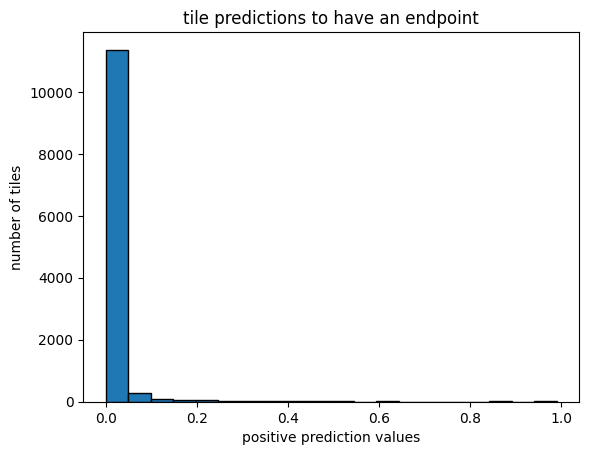

In [6]:
pos_threshold = 0.4
# how many tiles predicted to have an endpoint if we consider an endpoint as greater than pos_threshold probability
positiles = 0
for n in predictions_per_tile:
    if n > pos_threshold:
        positiles = positiles + 1
print(f"with a treshold of {pos_threshold}, {positiles} tiles of total {len(predictions_per_tile)} ({int(positiles / len(predictions_per_tile) * 100)}%) found to have an endpoint")

print("predictions: the higher a value, the more certain the model about the tile featuring signs of an endpoint ")
fig, ax = plt.subplots()
ax.hist(predictions_per_tile, bins=20, edgecolor='black')
ax.set_xlabel('positive prediction values')
ax.set_ylabel('number of tiles')
ax.set_title('tile predictions to have an endpoint')
plt.show()
writer.add_histogram(f"tile predictions for {pml_wsi.name.split('.')[-2]}", np.array(predictions_per_tile), global_step=None, bins=20, walltime=None, max_bins=None)


The chart helps finding the prediction value threshold for positive tiles i.e. over what value should we consider a tile to reflect an endpoint.


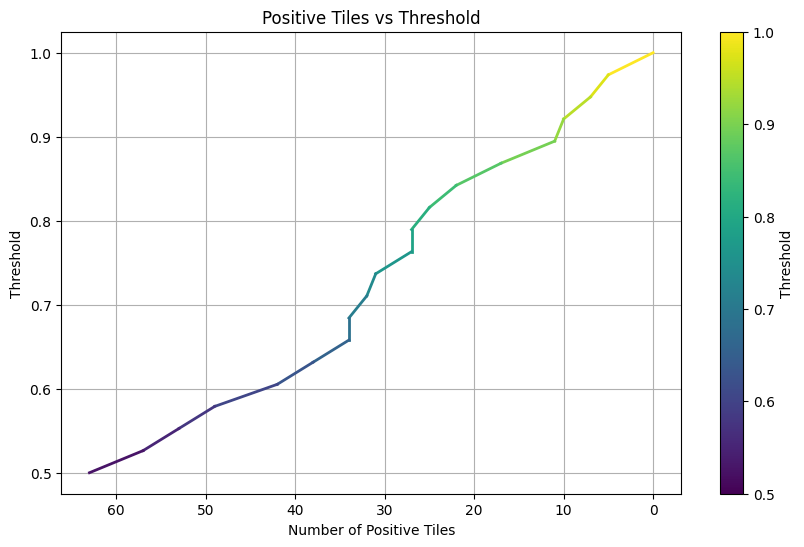

In [7]:
# display 'roc' curve #
#######################

import matplotlib.pyplot as plt
import numpy as np

print("The chart helps finding the prediction value threshold for positive tiles i.e. over what value should we consider a tile to reflect an endpoint.")
# create a range of thresholds
thresholds = np.linspace(1, 0.5, num=20)  # 50 thresholds from 0 to 1

positiles_per_threshold = []
# calculate positive tiles for each threshold
for threshold in thresholds:
    pt = 0
    for p in predictions_per_tile:
        if p > threshold:
            pt = pt + 1
    positiles_per_threshold.append(pt)

# positiles_per_threshold = [sum(p > threshold for p in pos_predictions) for threshold in thresholds]

# normalize threshold values for color mapping
norm = plt.Normalize(vmin=min(thresholds), vmax=max(thresholds))
cmap = plt.cm.viridis

fig, ax = plt.subplots(figsize=(10, 6))

# plot each segment with color mapping to the thresholds
for i in range(len(thresholds) - 1):
    color = cmap(norm(thresholds[i]))
    ax.plot(positiles_per_threshold[i:i+2], thresholds[i:i+2], color=color, lw=2)

# colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Important to ensure the colorbar works with our custom colors
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Threshold')

ax.set_xlabel('Number of Positive Tiles')
ax.set_ylabel('Threshold')
ax.set_title('Positive Tiles vs Threshold')

# mirror chart horizontally by reversing the x-axis
ax.set_xlim(ax.get_xlim()[::-1])

plt.grid(True)
plt.show()

writer.add_figure('Positive Tile vs Threshold', fig)

Working with pyramid resolution level 4 shape: (4672,)


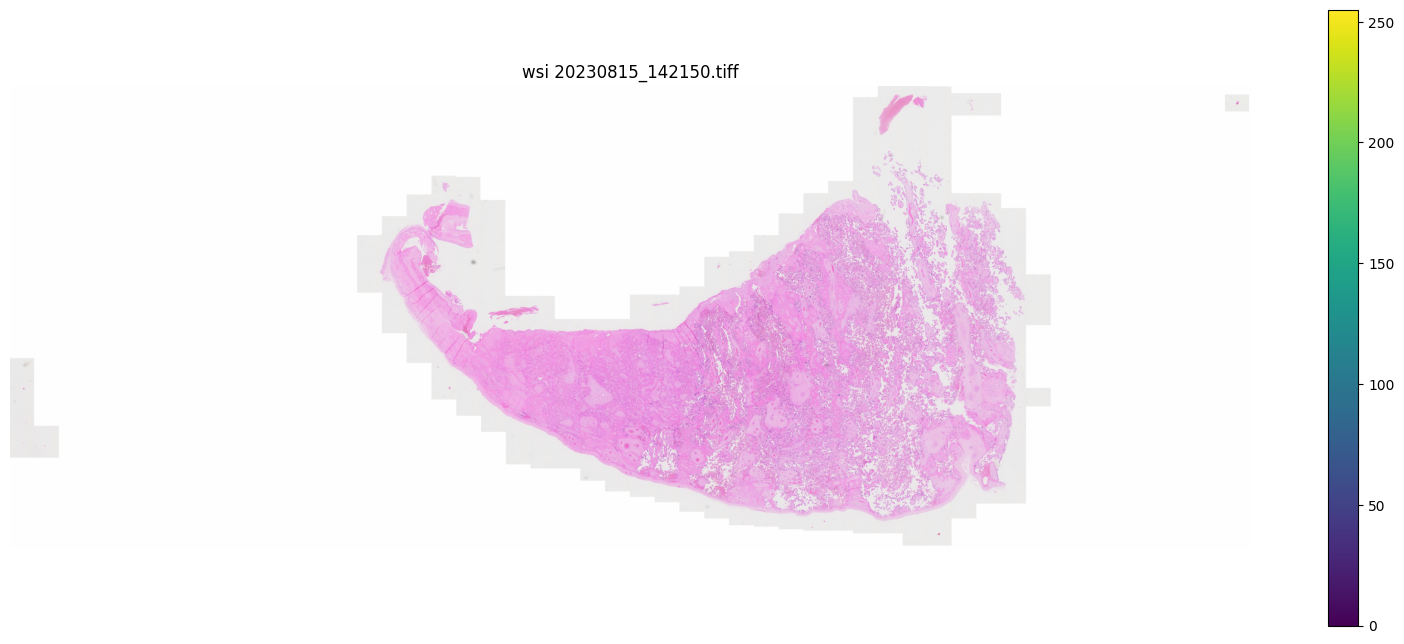

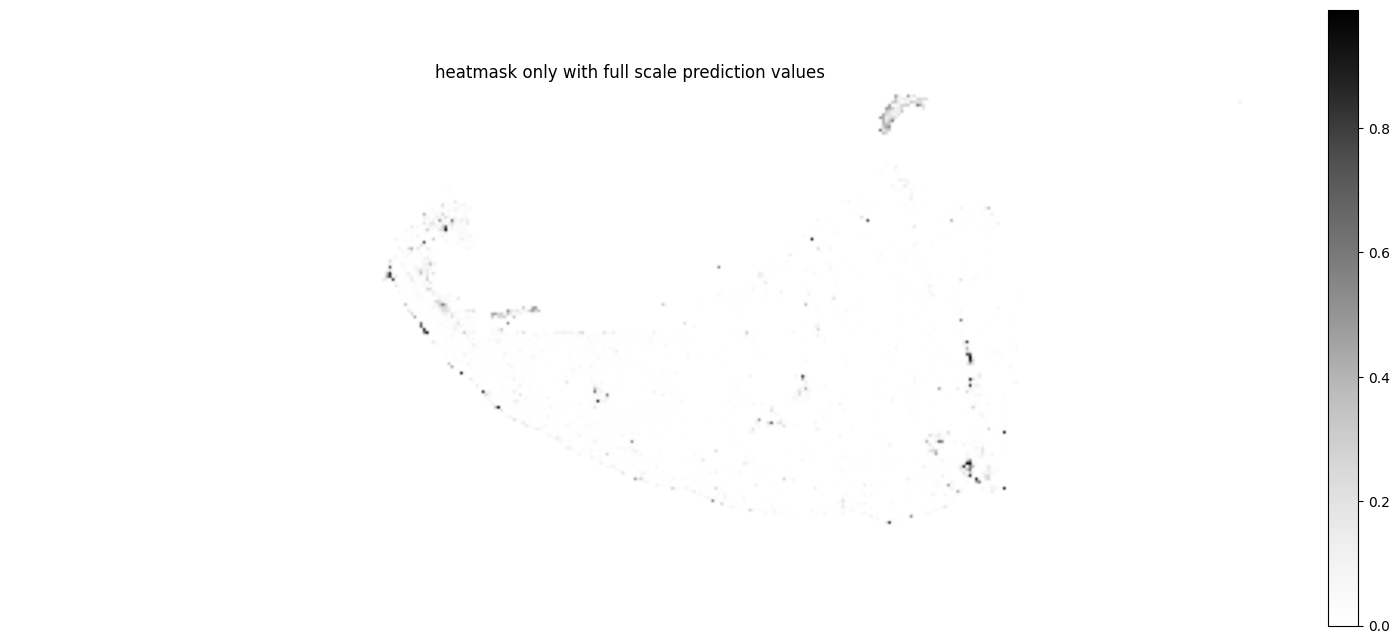

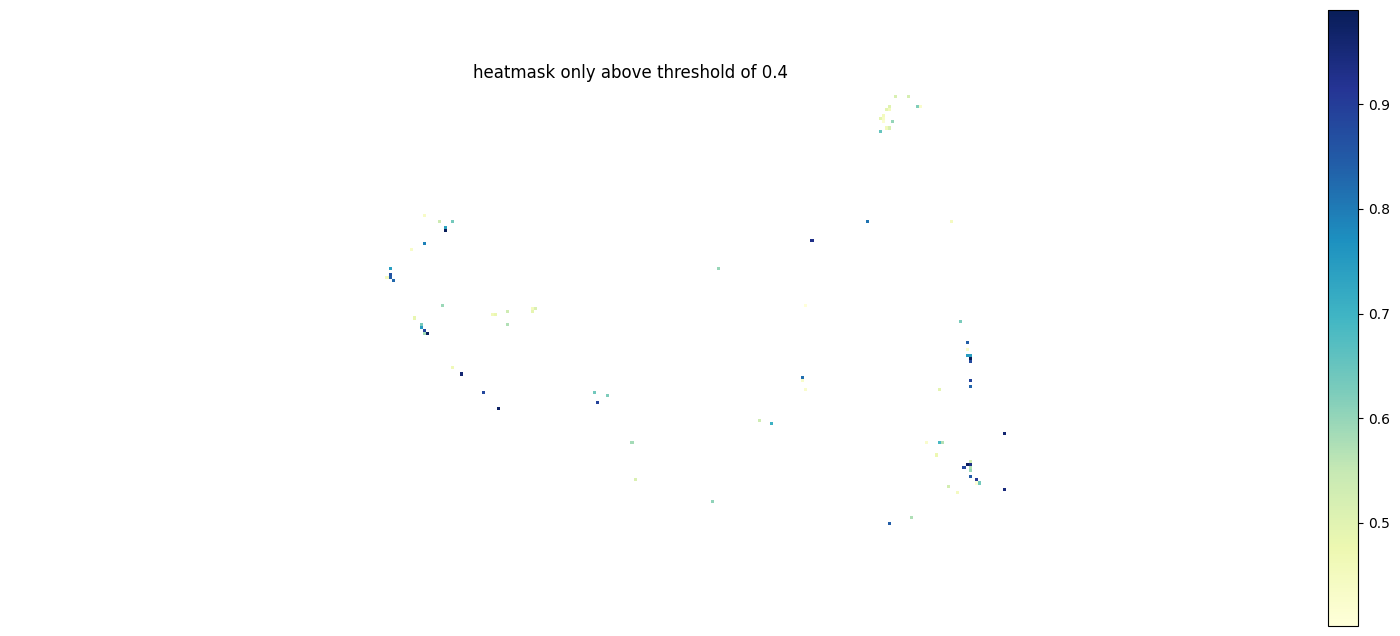

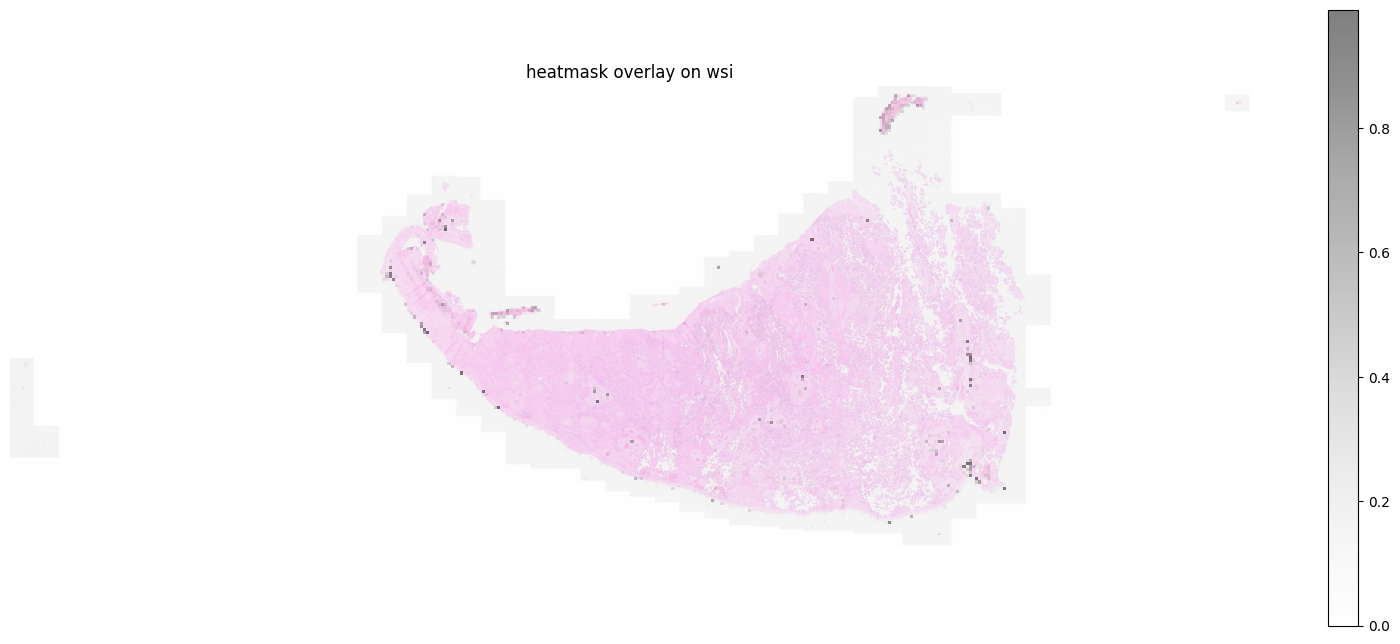

In [10]:
# display heatmask on wsi #
###########################
import numpy.ma as ma

try:
    resolution_level = 4   # 0 is the highest resolution, need to use the index of level_downsamples
    # dimensions are transposed!!! needed to invert.. (pml_wsi.slide.slide.level_dimensions[0][1], pml_wsi.slide.slide.level_dimensions[0][0]))
    region = pml_wsi.slide.extract_region(
        location=(0, 0),
        size=(pml_wsi.slide.slide.level_dimensions[resolution_level][1], pml_wsi.slide.slide.level_dimensions[resolution_level][0]),
        level=resolution_level
        )
    print("Working with pyramid resolution level", resolution_level, "shape:", region.shape[0:1])
except Exception as e:
    print("Resolution level not found, using original size. Error: ", e)
    # dimensions are transposed!!! needed to invert.. (pml_wsi.slide.slide.level_dimensions[0][1], pml_wsi.slide.slide.level_dimensions[0][0]))
    region = pml_wsi.slide.extract_region(
        location=(0, 0),
        size=(pml_wsi.slide.slide.level_dimensions[0][1], pml_wsi.slide.slide.level_dimensions[0][0])
        )

def customTile():
    return Tile(region, coords=(0, 0), name="testregion", slide_type=types.HE)

tile = customTile()

# display original image only
fig = plt.figure(figsize=(20, 8))
wsi_height, wsi_width = pml_wsi.shape
extent = [0, wsi_width, wsi_height, 0]
plt.imshow(region, extent=extent)
plt.colorbar()
plt.title(f'wsi {pml_wsi.name}')
plt.axis('off')
plt.show()

writer.add_figure('Original WSI', fig)

# display heatmask with all values
fig = plt.figure(figsize=(20, 8))
wsi_height, wsi_width = pml_wsi.shape
extent = [0, wsi_width, wsi_height, 0]
plt.imshow(heatmask, cmap='Greys', alpha=1, extent=extent, interpolation='hamming')
plt.colorbar()
plt.title('heatmask only with full scale prediction values')
plt.axis('off')
plt.show()

writer.add_figure('Full spectrum heatmask', fig)

# display heatmask with threshold
fig = plt.figure(figsize=(20, 8))
wsi_height, wsi_width = pml_wsi.shape
extent = [0, wsi_width, wsi_height, 0]
thresholded_heatmask = ma.masked_outside(heatmask, pos_threshold, 1)
plt.imshow(thresholded_heatmask, cmap='YlGnBu', alpha=1, extent=extent, interpolation='nearest')
plt.colorbar()
plt.title(f'heatmask only above threshold of {pos_threshold}')
plt.axis('off')
plt.show()

writer.add_figure(f'Heatmask only in range between {pos_threshold} and 1', fig)

# display heatmask drawn on wsi
plt.figure(figsize=(20, 8))
wsi_height, wsi_width = pml_wsi.shape
# extent = [0, wsi_width, wsi_height, 0] ??? also works 
extent = [0, wsi_width, wsi_height, 0]
plt.imshow(region, extent=extent)
plt.imshow(heatmask, cmap='Greys', alpha=0.5, extent=extent, interpolation='nearest')
plt.colorbar()
plt.title('heatmask overlay on wsi')
plt.axis('off')
plt.show()

writer.add_figure(f'Full spectrum heatmask overlay on wsi', fig)
writer.close()


In [9]:
# and play some music as well
import subprocess
mp3_file_path = '/home/peet/Downloads/clean-trap-loop-131bpm-136738.mp3'
subprocess.run(['mpg123', mp3_file_path])

High Performance MPEG 1.0/2.0/2.5 Audio Player for Layer 1, 2, and 3.
Version 0.3.2-1 (2012/03/25). Written and copyrights by Joe Drew,
now maintained by Nanakos Chrysostomos and others.
Uses code from various people. See 'README' for more!
THIS SOFTWARE COMES WITH ABSOLUTELY NO WARRANTY! USE AT YOUR OWN RISK!
tcgetattr(): Inappropriate ioctl for device

Directory: /home/peet/Downloads
Playing MPEG stream from clean-trap-loop-131bpm-136738.mp3 ...
MPEG 1.0 layer III, 256 kbit/s, 44100 Hz joint-stereo
                                                                            
[0:07] Decoding of clean-trap-loop-131bpm-136738.mp3 finished.


CompletedProcess(args=['mpg123', '/home/peet/Downloads/clean-trap-loop-131bpm-136738.mp3'], returncode=0)